# [Lab 03 - Implementacja propagacji wstecznej błędu](http://pages.mini.pw.edu.pl/~karwowskij/mioad/lab-sieci.html#org7777810)

Zaimplementować dwa usprawnienia uczenia gradientowego sieci neuronowej:

* moment,
* normalizację gradientu RMSProp.

Porównać szybkość zbieżności procesu uczenia dla obu wariantów.

Przeprowadzić eksperymenty na zbiorach:

* square-large,
* steps-large,
* multimodal-large.


In [38]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import metrics
import copy

## Model

In [44]:
class MLP:

    def __init__(self, layers, weights, biases, visualize_weights = False):
        self.layers = copy.deepcopy(layers)
        self.weights = copy.deepcopy(weights)
        self.biases = copy.deepcopy(biases)

        self.derivative_w = []
        self.derivative_b = []
        self.visualize_weights = visualize_weights


    def forward(self, inputs):
        """
        performs forward propagation
        """
        # activations and linear combinations passed to activation function
        self.activations = []
        self.z_values = []

        activations = inputs
        self.activations.append(activations)
        for i in range(len(self.layers)-2):

            outputs = activations @ self.weights[i] + self.biases[i]
            self.z_values.append(outputs)
            activations = self.sigmoid(outputs)
            self.activations.append(activations)
        
        self.weights[-1].shape
        results = activations @ self.weights[-1] + self.biases[-1]
        self.z_values.append(results)
        self.activations.append(results)
        return results


    def backpropagation(self, y):
        deltas = [None] * len(self.weights)
        deltas[-1] = y - self.activations[-1]

        for i in reversed(range(len(deltas) - 1)):
            deltas[i] = ((self.weights[i + 1] @ deltas[i + 1].T ) * self.sigmoidGradient(self.z_values[i]).T).T

        m = y.shape[0]

        derivative_b = [None] * len(deltas)
        derivative_w = [None] * len(deltas)

        for i, d in enumerate(deltas):
            derivative_w[i] = (d.T @ self.activations[i]).T / m
            derivative_b[i] = (d.T @ np.ones((m, 1))).T / m

        return derivative_w, derivative_b

    def train(self, x, y, batch_size=20, epochs=500, alpha=0.1, verbose=False, momentum = False, rmsprop = False, lambda_moment = 0.5, beta = 0.5):

        p = np.random.permutation(len(y))
        x = x[p]
        y = y[p]

        momentum_w = [np.zeros(w.shape) for w in self.weights]
        momentum_b = [np.zeros(b.shape) for b in self.biases]
        
        rmsprop_w = [np.zeros(w.shape) for w in self.weights]
        rmsprop_b = [np.zeros(b.shape) for b in self.biases]
         
        
        for epoch in range(epochs):
            i = 0
            
            while i < len(y):
                x_batch = x[i:i + batch_size]
                y_batch = y[i:i + batch_size]
                i = i + batch_size
                y_hat = self.forward(x_batch)
                derivative_w, derivative_b = self.backpropagation(y_batch)

                for j, weight in enumerate(self.weights):

                    if momentum: 
                        momentum_w[j] = momentum_w[j] * lambda_moment + derivative_w[j]
                        self.weights[j] = weight + alpha * momentum_w[j]
                    
                    elif rmsprop: 
                        rmsprop_w[j] = beta * rmsprop_w[j] + (1-beta) * derivative_w[j] ** 2
                        self.weights[j] = weight + alpha * (derivative_w[j]/np.sqrt(rmsprop_w[j]))
                        
                    else:
                        self.weights[j] = weight + alpha * derivative_w[j]

                for j, bias in enumerate(self.biases):

                    if momentum: 
                        momentum_b[j] = momentum_b[j] * lambda_moment + derivative_b[j]
                        self.biases[j] = bias + alpha * momentum_b[j]
                    
                    elif rmsprop: 
                        rmsprop_b[j] = beta * rmsprop_b[j] + (1-beta) * derivative_b[j] ** 2
                        self.biases[j] = bias + alpha * (derivative_b[j]/np.sqrt(rmsprop_b[j]))
                    
                    else:
                        self.biases[j] = bias + alpha * derivative_b[j]     
            

            if self.visualize_weights:
                if epoch%100 == 0:
                    
                    print("Error in epoch {} = {}".format(epoch, np.linalg.norm(self.activations[-1] - y_batch)))
                    network_structure = np.asarray(layers)
                    network=visNN.DrawNN(network_structure, self.weights)
                    network.draw()
            else: 
                print("Error in epoch {} = {}".format(epoch, np.linalg.norm(self.activations[-1] - y_batch)), end = '\r')


    @staticmethod
    def sigmoid(x):
        return np.exp(x) / (1 + np.exp(x))

    @staticmethod
    def sigmoidGradient(x):
        def sigmoid(x):
            return np.exp(x) / (1 + np.exp(x))
        return sigmoid(x) * (1 - sigmoid(x))

In [45]:
def generate_weights_and_biases(layers, lower, upper):

    weights = []
    biases = []

    for i in range(len(layers) - 1):
        weights.append(np.random.uniform(lower, upper, layers[i] * layers[i + 1]).reshape(layers[i], layers[i + 1]))
        biases.append(np.random.uniform(lower, upper, layers[i + 1]).reshape(1, layers[i+1]))

    return weights, biases

# Testowanie usprawnień sieci na danych
Dla każdego zbioru danych wykonamy następujący eksperyment: 
* dla każdego usprawnienia (oraz bazowej implementacji) wytrenujemy sieć neuronową (takie same wagi początkowe, taka sama architektura) 
* ze względu na charakter losowy doboru wag dla każdej z epoch zostanie wytrenowana 5 razy
* tak będziemy robić dla każdej z predefiniowanego zestawu epoch
* parametry (`alpha` `beta` `lambda`) zostały ustawione przeze mnie ręcznie i dobrane według mnie w optymalny sposób
* na sam koniec dla każdego zbioru wykonany zostanie plot przedstawiający szybkość zbieżności każdej metody

## Square simple

In [ ]:
train_df = pd.read_csv('../data/square-simple-training.csv', index_col=0)
test_df = pd.read_csv('../data/square-simple-test.csv', index_col=0)

x = np.asarray(train_df['x']).reshape(-1, 1)
y = np.asarray(train_df['y']).reshape(-1, 1)
x_test = np.asarray(test_df['x']).reshape(-1,1)



### Zestaw epoch

In [53]:
epochs_range = np.array([10, 50, 100, 200, 300, 500, 800, 1000, 2000, 5000])

In [94]:
mean_results_base = []
mean_results_moment = []
mean_results_rmsprop = []
for num_epochs in epochs_range:
    results_b = []
    results_m = []
    results_r = []
    
    for _ in range(5):
        weights, biases = generate_weights_and_biases(layers, -1, 1)
        mlp_b = MLP(layers, weights, biases)
        mlp_m = MLP(layers, weights, biases)
        mlp_r = MLP(layers, weights, biases)
        
        mlp_b.train(x, y, epochs = num_epochs, alpha=0.001)
        mlp_m.train(x, y, epochs = num_epochs, alpha=0.01, momentum = True, lambda_moment = 0.1)
        mlp_r.train(x, y, epochs = num_epochs, alpha=0.1, rmsprop = True, beta = 0.9)

        predictions_b = mlp_b.forward(x_test)
        predictions_m = mlp_m.forward(x_test)
        predictions_r = mlp_r.forward(x_test)

        results_b.append(metrics.mean_absolute_error(test_df['y'], predictions_b))
        results_m.append(metrics.mean_absolute_error(test_df['y'], predictions_m))
        results_r.append(metrics.mean_absolute_error(test_df['y'], predictions_r))
        
        
    mean_results_base.append(np.array(results_b).mean())
    mean_results_moment.append(np.array(results_m).mean())
    mean_results_rmsprop.append(np.array(results_r).mean())
    

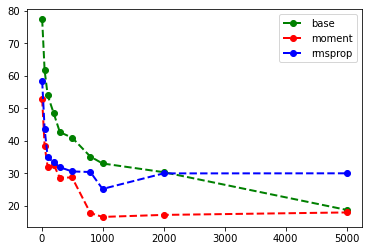

In [95]:
plt.plot(epochs_range, mean_results_base, color='green', marker='o', linestyle='dashed', linewidth=2, label='base')
plt.plot(epochs_range, mean_results_moment, color='red', marker='o', linestyle='dashed', linewidth=2, label='moment')
plt.plot(epochs_range, mean_results_rmsprop, color='blue', marker='o', linestyle='dashed', linewidth=2, label='rmsprop')
plt.legend()
plt.show()

### Wnioski
Najszybciej zbiegł `moment`, już po 1000 epoch był on w dość optymalnym punkcie. Kolejny szybko zbiegł `rmsprop` (należałoby jednak delikatnie zmniejszyć learning rate). Na końcu `base` i `moment` osiągnęły najmniejszy błąd.

## multimodal-small

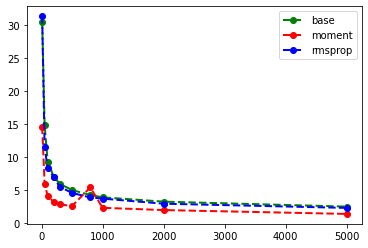

In [107]:
train_df = pd.read_csv('../data/multimodal-small-training.csv', index_col=0)
test_df = pd.read_csv('../data/multimodal-small-test.csv', index_col=0)

x = np.asarray(train_df['x']).reshape(-1, 1)
y = np.asarray(train_df['y']).reshape(-1, 1)
x_test = np.asarray(test_df['x']).reshape(-1,1)

layers=[1, 10, 1]
weights, biases = generate_weights_and_biases(layers, -1, 1)

mean_results_base = []
mean_results_moment = []
mean_results_rmsprop = []
for num_epochs in epochs_range:
    results_b = []
    results_m = []
    results_r = []
    
    for _ in range(5):
        weights, biases = generate_weights_and_biases(layers, -1, 1)
        mlp_b = MLP(layers, weights, biases)
        mlp_m = MLP(layers, weights, biases)
        mlp_r = MLP(layers, weights, biases)
        
        mlp_b.train(x, y, epochs = num_epochs, alpha=0.01)
        mlp_m.train(x, y, epochs = num_epochs, alpha=0.1, momentum = True, lambda_moment = 0.1)
        mlp_r.train(x, y, epochs = num_epochs, alpha=0.1, rmsprop = True, beta = 0.98)

        predictions_b = mlp_b.forward(x_test)
        predictions_m = mlp_m.forward(x_test)
        predictions_r = mlp_r.forward(x_test)

        results_b.append(metrics.mean_absolute_error(test_df['y'], predictions_b))
        results_m.append(metrics.mean_absolute_error(test_df['y'], predictions_m))
        results_r.append(metrics.mean_absolute_error(test_df['y'], predictions_r))
        
        
    mean_results_base.append(np.array(results_b).mean())
    mean_results_moment.append(np.array(results_m).mean())
    mean_results_rmsprop.append(np.array(results_r).mean())

plt.plot(epochs_range, mean_results_base, color='green', marker='o', linestyle='dashed', linewidth=2, label='base')
plt.plot(epochs_range, mean_results_moment, color='red', marker='o', linestyle='dashed', linewidth=2, label='moment')
plt.plot(epochs_range, mean_results_rmsprop, color='blue', marker='o', linestyle='dashed', linewidth=2, label='rmsprop')
plt.legend()
plt.show()

### Wnioski

Najlepiej sprawdził się w tym wypadku `moment`, zbiegł on najszybciej i doszedł do mniejszego błędu. Marginalnie lepszy od bazowego był również `rmsprop`

## multimodal-large

In [139]:
epochs_range = np.array([10, 50, 100, 200, 300, 500, 800, 1000, 2000])

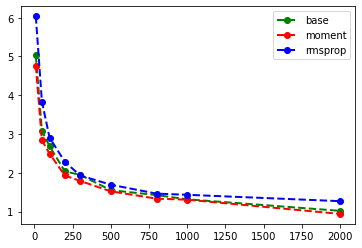

In [140]:
train_df = pd.read_csv('../data/multimodal-large-training.csv', index_col=0)
test_df = pd.read_csv('../data/multimodal-large-test.csv', index_col=0)

x = np.asarray(train_df['x']).reshape(-1, 1)
y = np.asarray(train_df['y']).reshape(-1, 1)
x_test = np.asarray(test_df['x']).reshape(-1,1)

layers=[1, 10, 1]
weights, biases = generate_weights_and_biases(layers, -1, 1)

mean_results_base = []
mean_results_moment = []
mean_results_rmsprop = []
for num_epochs in epochs_range:
    results_b = []
    results_m = []
    results_r = []
    
    
    for _ in range(5):
        weights, biases = generate_weights_and_biases(layers, -1, 1)
        mlp_b = MLP(layers, weights, biases)
        mlp_m = MLP(layers, weights, biases)
        mlp_r = MLP(layers, weights, biases)
        
        mlp_b.train(x, y, epochs = num_epochs, alpha=0.01)
        mlp_m.train(x, y, epochs = num_epochs, alpha=0.01, momentum = True, lambda_moment = 0.2)
        mlp_r.train(x, y, epochs = num_epochs, alpha=0.05, rmsprop = True, beta = 0.98)

        predictions_b = mlp_b.forward(x_test)
        predictions_m = mlp_m.forward(x_test)
        predictions_r = mlp_r.forward(x_test)

        results_b.append(metrics.mean_absolute_error(test_df['y'], predictions_b))
        results_m.append(metrics.mean_absolute_error(test_df['y'], predictions_m))
        results_r.append(metrics.mean_absolute_error(test_df['y'], predictions_r))
        
        
    mean_results_base.append(np.array(results_b).mean())
    mean_results_moment.append(np.array(results_m).mean())
    mean_results_rmsprop.append(np.array(results_r).mean())

plt.plot(epochs_range, mean_results_base, color='green', marker='o', linestyle='dashed', linewidth=2, label='base')
plt.plot(epochs_range, mean_results_moment, color='red', marker='o', linestyle='dashed', linewidth=2, label='moment')
plt.plot(epochs_range, mean_results_rmsprop, color='blue', marker='o', linestyle='dashed', linewidth=2, label='rmsprop')
plt.legend()
plt.show()

### Wnioski
W tym przykładzie nie ma tak dużej przewagi jakiejkolwiek z sieci. Widać, że najszybciej zbiega `moment` a najwolniej `rmsprop`